#### Импорт библиотек

In [44]:
import numpy as np

import torch 
from torch import nn, optim 
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from IPython.display import clear_output

import time 

from lib import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
%load_ext autoreload
%autoreload 2

#### Конструктор сети

In [57]:
# Чтобы заменить линейные слои на кастомные с ТТ-разложением, надо закомментировать 1 и 2 и заменить на TT_linear

class Net(nn.Module):
    def __init__(self, use_TT_linear=False, ues_TT_conv=False):
        super().__init__()
        
        conv = TT_conv([2, 2, 2], [2, 4, 2], [1, 2, 1], 3, 3) if ues_TT_conv else nn.Conv2d(8, 16, 3)
        
        linear_1 = TT_linear([4, 4, 13, 2, 13, 2], 
                             [2, 4, 2, 2, 4, 2], 
                             [1, 2, 2, 2, 2, 2, 1]) if use_TT_linear else nn.Linear(16 * 26 * 26, 256)
        
            
        linear_2 = TT_linear([2, 4, 2, 2, 4, 2], 
                             [2, 2, 2, 2, 2, 2], 
                             [1, 2, 2, 2, 2, 2, 1]) if use_TT_linear else nn.Linear(256, 64)

            
        self.net = nn.Sequential(
            nn.Conv2d(1, 8, 5, padding=2), nn.ReLU(),
            conv, nn.ReLU(),
            nn.Flatten(), 
            linear_1, nn.ReLU(),
            linear_2, nn.ReLU(),
            nn.Linear(64, 10), nn.Softmax(dim=1)
        )

        
    def forward(self, x):
        return self.net(x)
    
    def params_amount(self):
        # возвращает общее число параметров сети 
        
        params = list(self.parameters())
        N_params = 0
        for p in params:
            size = p.data.shape
#             print(size, size.numel())
            N_params += size.numel()
        return N_params

####  Загрузка датасета

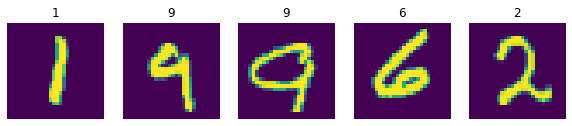

In [9]:
# MNIST
train_dataloader, test_dataloader = download_dataset('mnist')
show_sample_from_dataset(train_dataloader)

# CIFAR-10
# train_dataloader, test_dataloader, classes = download_dataset('cifar-10')
# show_sample_from_dataset(train_dataloader, classes)

#### Обучение сети

Без ТТ-разложения:

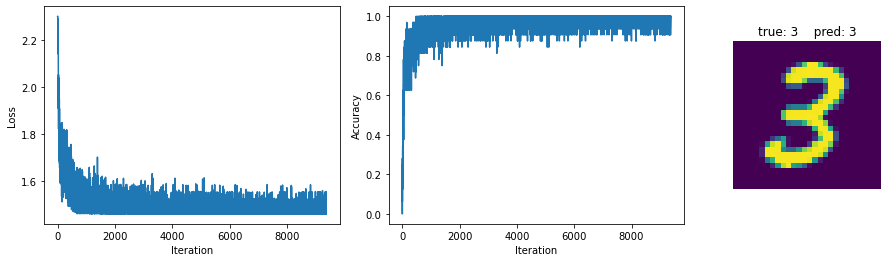

train loss: 1.461
train accuracy: 1.000
test  accuracy: 0.980
total params amount: 2787626


In [107]:
model = Net(False, False).to(device)
N_params_0_0, accuracy_0_0 = check(model, train_dataloader, test_dataloader, n_epochs=5, show=True)

С ТТ-разложением:

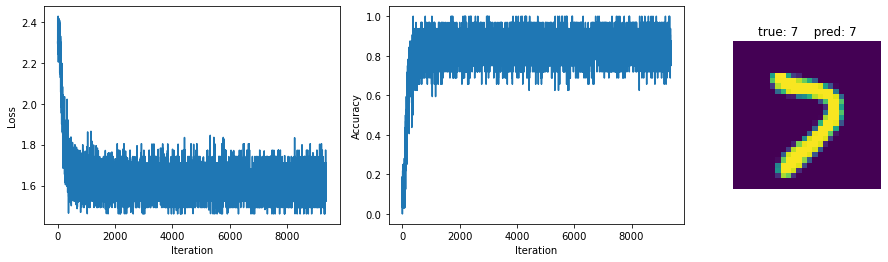

train loss: 1.555
train accuracy: 0.906
test  accuracy: 0.857
total params amount: 2786526


In [114]:
model_TT = Net(False, True).to(device)
N_params_0_1, accuracy_0_1 = check(model_TT, train_dataloader, test_dataloader, n_epochs=5, show=True)

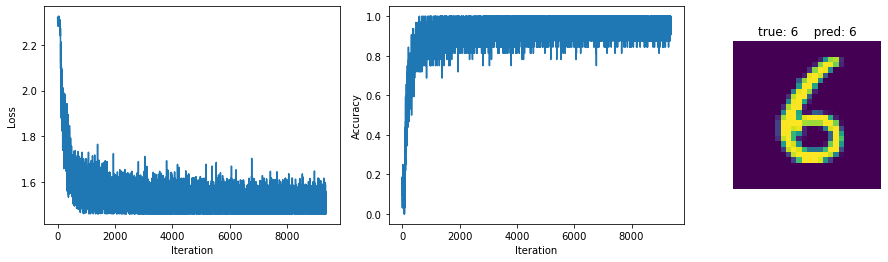

train loss: 1.584
train accuracy: 0.875
test  accuracy: 0.959
total params amount: 2874


In [118]:
model_TT = Net(True, False).to(device)
N_params_1_0, accuracy_1_0 = check(model_TT, train_dataloader, test_dataloader, n_epochs=5, show=True)

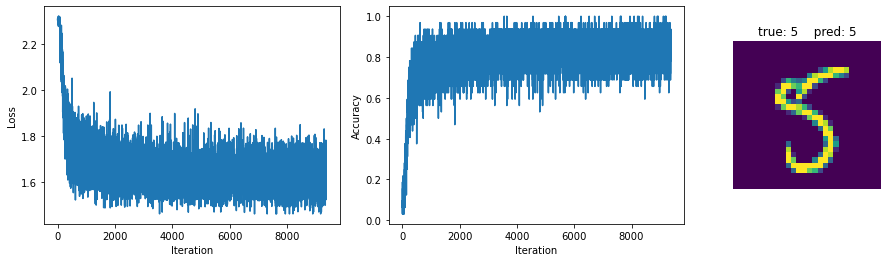

train loss: 1.588
train accuracy: 0.875
test  accuracy: 0.837
total params amount: 1774


In [121]:
model_TT = Net(True, True).to(device)
N_params_1_1, accuracy_1_1 = check(model_TT, train_dataloader, test_dataloader, n_epochs=5, show=True)

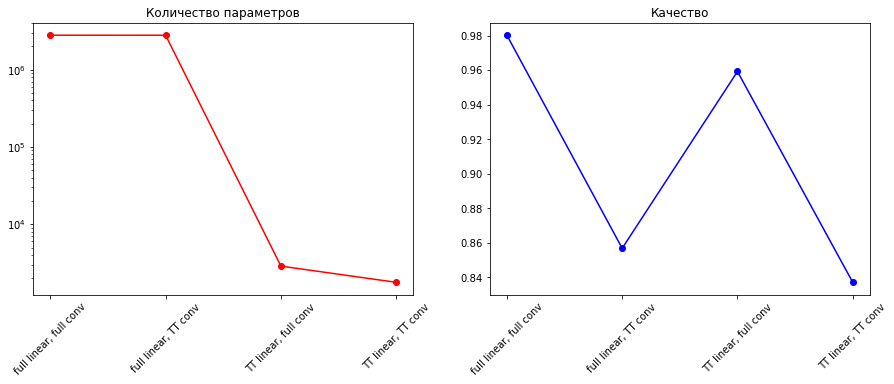

In [122]:
labels = ('full linear, full conv', 'full linear, TT conv',
          'TT linear, full conv', 'TT linear, TT conv')
N_params_s = [N_params_0_0, N_params_0_1, N_params_1_0, N_params_1_1]
accuracy_s = [accuracy_0_0, accuracy_0_1, accuracy_1_0, accuracy_1_1]

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Количество параметров')
plt.plot(N_params_, '-o', c='red')
plt.yscale('log')
plt.xticks(range(len(labels)), labels=labels, rotation=45)

plt.subplot(1, 2, 2)
plt.title('Качество')
plt.plot(accuracy_s, '-o', c='blue')
plt.xticks(range(len(labels)), labels=labels, rotation=45)

plt.show()

In [123]:
print('Число параметров:')
print(f'    Было : {N_params_0_0}')
print(f'    Стало: {N_params_1_1}')
print(f'    Уменьшилось в {N_params_0_0 / N_params_1_1 :.2f} раз\n')

print('Точность:')
print(f'    Было : {accuracy_0_0 * 100:.2f}%')
print(f'    Стало: {accuracy_1_1 * 100:.2f}%')
print(f'    Уменьшилось на {100 * (accuracy_0_0 - accuracy_1_1):.2f}%')

Число параметров:
    Было : 2787626
    Стало: 1774
    Уменьшилось в 1571.38 раз

Точность:
    Было : 98.02%
    Стало: 83.71%
    Уменьшилось на 14.31%


In [ ]:
# Чтобы заменить линейные слои на кастомные с ТТ-разложением, надо закомментировать 1 и 2 и заменить на TT_linear

class Net(nn.Module):
    def __init__(self, use_TT_linear=False, use_low_rank=False):
        super().__init__()
        
        ranks = [1, 2, 2, 2, 1] if use_low_rank else [1, 4, 4, 4, 1]
                
        linear_1 = TT_linear([4, 7, 4, 7], 
                             [4, 8, 4, 8], 
                             ranks) if use_TT_linear else nn.Linear(28 * 28, 1024)
        
            
        linear_2 = TT_linear([4, 8, 4, 8], 
                             [4, 4, 4, 4], 
                             ranks) if use_TT_linear else nn.Linear(1024, 256)

            
        self.net = nn.Sequential(
            nn.Flatten(), 
            linear_1, nn.ReLU(),
            linear_2, nn.ReLU(),
            nn.Linear(256, 10), nn.Softmax(dim=1)
        )

        
    def forward(self, x):
        return self.net(x)
    
    def params_amount(self):
        # возвращает общее число параметров сети 
        
        params = list(self.parameters())
        N_params = 0
        for p in params:
            size = p.data.shape
#             print(size, size.numel())
            N_params += size.numel()
        return N_params

In [ ]:
model = Net(False, False).to(device)
N_params_0, accuracy_0 = check(model, train_dataloader, test_dataloader, n_epochs=5, show=True)

In [ ]:
model = Net(True, False).to(device)
N_params_1_0, accuracy_1_0 = check(model, train_dataloader, test_dataloader, n_epochs=5, show=True)

In [ ]:
model = Net(True, True).to(device)
N_params_1_1, accuracy_1_1 = check(model, train_dataloader, test_dataloader, n_epochs=5, show=True)

In [ ]:
labels = ('full', 'TT + max ranks', 'TT + low ranks')
N_params_s = [N_params_0, N_params_1_0, N_params_1_1]
accuracy_s = [accuracy_0, accuracy_1_0, accuracy_1_1]

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.title('Количество параметров')
plt.plot(N_params_s, '-o', c='red')
plt.yscale('log')
plt.xticks(range(len(labels)), labels=labels)

plt.subplot(1, 2, 2)
plt.title('Качество')
plt.plot(accuracy_s, '-o', c='blue')
plt.xticks(range(len(labels)), labels=labels)

plt.savefig('fig', dpi='figure', facecolor='white')
plt.show()

In [ ]:
print('Число параметров:')
print(f'    Было : {N_params_0}')
print(f'    Стало: {N_params_1_1}')
print(f'    Уменьшилось в {N_params_0 / N_params_1_1 :.2f} раз\n')

print('Точность:')
print(f'    Было : {accuracy_0 * 100:.2f}%')
print(f'    Стало: {accuracy_1_1 * 100:.2f}%')
print(f'    Уменьшилось на {100 * (accuracy_0 - accuracy_1_1):.2f}%')